In [1]:
#Cell 0
import os
import json
import zlib
import base64
from io import BytesIO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Concatenate, BatchNormalization, Dense,
    GlobalAveragePooling2D, Dropout, Activation
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


2025-05-11 22:25:47.650834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747002347.832532      66 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747002347.885122      66 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#cell 1
def setup_gpus():
    """Configure TensorFlow to use multiple GPUs with MirroredStrategy"""
    print("Setting up GPUs...")
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("GPUs set up successfully")
            return len(gpus)
        except RuntimeError as e:
            print(f"GPU setup error: {e}")
            return 0
    else:
        print("No GPUs found")
        return 0

num_gpus = setup_gpus()
strategy = tf.distribute.MirroredStrategy() if num_gpus > 1 else tf.distribute.get_strategy()
print(f"Using strategy: {strategy.__class__.__name__}")

Setting up GPUs...
GPUs set up successfully
Using strategy: MirroredStrategy


I0000 00:00:1747002359.532709      66 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747002359.533344      66 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [3]:
#Cell 2
def decode_bitmap(json_path, target_size=(256, 256)):
    try:
        with open(json_path, 'r') as f:
            annotation = json.load(f)
        objects = annotation.get('objects', [])
        bitmap_obj = next((obj['bitmap'] for obj in objects if 'bitmap' in obj), None)
        if not bitmap_obj:
            return np.zeros(target_size, dtype=np.uint8)
        decoded = base64.b64decode(bitmap_obj['data'])
        decompressed = zlib.decompress(decoded)
        mask_pil = Image.open(BytesIO(decompressed))
        mask = np.array(mask_pil)
        origin = bitmap_obj.get('origin', [0, 0])
        x_start, y_start = int(origin[0]), int(origin[1])
        full_height = annotation.get('size', {}).get('height', target_size[1])
        full_width = annotation.get('size', {}).get('width', target_size[0])
        full_mask = np.zeros((full_height, full_width), dtype=np.uint8)
        h, w = mask.shape[:2]
        y_end = min(y_start + h, full_height)
        x_end = min(x_start + w, full_width)
        clipped_mask = mask[:y_end - y_start, :x_end - x_start]
        full_mask[y_start:y_end, x_start:x_end] = clipped_mask
        return cv2.resize(full_mask, target_size, interpolation=cv2.INTER_NEAREST)
    except Exception as e:
        return np.zeros(target_size, dtype=np.uint8)

In [4]:
#Cell 3
def load_data(image_dir, mask_dir, target_size=(256, 256)):
    images, masks, classes = [], [], []
    print("Loading and preprocessing data...")
    for filename in os.listdir(image_dir):
        if not filename.endswith('.png'):
            continue
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = img.astype(np.float32) / 255.0
        img = cv2.resize(img, target_size)
        images.append(img)
        cls_name = filename.split(' ')[0].lower()
        if 'normal' in cls_name:
            classes.append(0)
        elif 'benign' in cls_name:
            classes.append(1)
        elif 'malignant' in cls_name:
            classes.append(2)
        else:
            continue
        json_path = os.path.join(mask_dir, filename + '.json')
        mask = decode_bitmap(json_path, target_size=target_size)
        masks.append(cv2.resize(mask, target_size))

    valid_idx = np.array(classes) != -1
    images = np.array(images)[valid_idx]
    masks = np.array(masks)[valid_idx]
    classes = np.array(classes)[valid_idx]
    images = np.expand_dims(images, axis=-1)
    masks = np.expand_dims(masks, axis=-1)

    print(f"Loaded {len(images)} samples.")
    return images, masks, classes

In [5]:
#Cell 4
image_dir = '/kaggle/input/breast-cancer/ds/img'
mask_dir = '/kaggle/input/breast-cancer/ds/ann'

images, masks, classes = load_data(image_dir, mask_dir)

X_train_val, X_test, y_seg_train_val, y_seg_test, y_cls_train_val, y_cls_test = train_test_split(
    images, masks, classes, test_size=0.15, random_state=42, stratify=classes
)

X_train, X_val, y_seg_train, y_val_seg, y_cls_train, y_val_cls = train_test_split(
    X_train_val, y_seg_train_val, y_cls_train_val, test_size=0.176, random_state=42, stratify=y_cls_train_val
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Loading and preprocessing data...
Loaded 780 samples.
Train: 546, Val: 117, Test: 117


In [6]:
#Cell 5
def create_dataset(X, y_seg, y_cls, batch_size=8, is_training=False):

    y_cat = tf.keras.utils.to_categorical(y_cls, num_classes=3)

    dataset = tf.data.Dataset.from_tensor_slices((
        X.astype(np.float32),
        {
            'seg_output': y_seg.astype(np.float32),
            'cls_output': y_cat.astype(np.float32)
        }
    ))
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=False)

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [7]:
#Cell 6
def build_unet_with_classification(input_shape=(256, 256, 1), num_classes=3):
    inputs = Input(shape=input_shape)

    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    bottleneck = Conv2D(512, 3, padding='same')(pool3)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)

    up3 = UpSampling2D(size=(2, 2))(bottleneck)
    concat3 = Concatenate()([up3, conv3])
    up_conv3 = Conv2D(256, 3, padding='same')(concat3)
    up_conv3 = BatchNormalization()(up_conv3)
    up_conv3 = Activation('relu')(up_conv3)

    up2 = UpSampling2D(size=(2, 2))(up_conv3)
    concat2 = Concatenate()([up2, conv2])
    up_conv2 = Conv2D(128, 3, padding='same')(concat2)
    up_conv2 = BatchNormalization()(up_conv2)
    up_conv2 = Activation('relu')(up_conv2)

    up1 = UpSampling2D(size=(2, 2))(up_conv2)
    concat1 = Concatenate()([up1, conv1])
    up_conv1 = Conv2D(64, 3, padding='same')(concat1)
    up_conv1 = BatchNormalization()(up_conv1)
    up_conv1 = Activation('relu')(up_conv1)

    seg_output = Conv2D(1, 1, activation='sigmoid', name='seg_output')(up_conv1)

    cls_pool = GlobalAveragePooling2D()(bottleneck)
    cls_dense1 = Dense(256, activation='relu')(cls_pool)
    cls_dense1 = Dropout(0.5)(cls_dense1)
    cls_output = Dense(num_classes, activation='softmax', name='cls_output')(cls_dense1)

    return Model(
    inputs=inputs,
    outputs={
        'seg_output': seg_output,
        'cls_output': cls_output
        }
    )

In [8]:
#Cell 7
batch_size = 8

train_dataset = create_dataset(X_train, y_seg_train, y_cls_train, batch_size=batch_size, is_training=True)
val_dataset = create_dataset(X_val, y_val_seg, y_val_cls, batch_size=batch_size, is_training=False)

In [9]:
# Cell 8
with strategy.scope():
    model = build_unet_with_classification()

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss={
            'seg_output': 'binary_crossentropy',
            'cls_output': 'categorical_crossentropy'
        },
        metrics={
            'seg_output': ['accuracy'],
            'cls_output': ['accuracy']
        },
        loss_weights={'seg_output': 0.5, 'cls_output': 0.5}
    )

    model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 128)  │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 512)    │          2,048 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 32, 32, 512)    │              0 │ batch_normalization_3… │
├──────────────────────

 Total params: 4,010,500 (15.30 MB)

 Trainable params: 4,007,684 (15.29 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [10]:
#Cell 9
batch_size = 8

train_dataset = create_dataset(X_train, y_seg_train, y_cls_train, batch_size=batch_size, is_training=True)
val_dataset = create_dataset(X_val, y_val_seg, y_val_cls, batch_size=batch_size, is_training=False)

with strategy.scope():
    model = build_unet_with_classification()
    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer,
        loss={
            'seg_output': 'binary_crossentropy',
            'cls_output': 'categorical_crossentropy'
        },
        metrics={
            'seg_output': ['accuracy'],
            'cls_output': ['accuracy']
        },
        loss_weights={'seg_output': 0.5, 'cls_output': 0.5}
    )
    model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 256, 256, 64)   │            640 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 256, 256, 64)   │            256 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_7 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 128, 128, 64)   │              0 │ activation_7[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 128, 128, 128)  │            512 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_8 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 128)    │              0 │ activation_8[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 64, 64, 256)    │          1,024 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_9 (Activation) │ (None, 64, 64, 256)    │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 256)    │              0 │ activation_9[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 32, 32, 512)    │          2,048 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10        

 Total params: 4,010,500 (15.30 MB)

 Trainable params: 4,007,684 (15.29 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
#Cell 10
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=5),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

for batch in train_dataset.take(1):
    print("Input shape:", batch[0].shape)
    labels = batch[1]
    for key in labels:
        print(f"{key} shape:", labels[key].shape)

print("Starting training...")

try:
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50,
        callbacks=callbacks,
        verbose=1
    )
    print("Training completed.")
except Exception as e:
    print("Training failed due to shape mismatch or invalid data:")
    print(str(e))
    print("\n💡 Tip: Check:")
    print(" - Segmentation head outputs spatial maps (e.g., (None, 256, 256, 1))")
    print(" - Classification head outputs class probabilities (e.g., (None, 3))")
    print(" - Dataset labels match these shapes exactly")

Input shape: (8, 256, 256, 1)
seg_output shape: (8, 256, 256, 1)
cls_output shape: (8, 3)
Starting training...
Epoch 1/50


I0000 00:00:1747002395.367650     101 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747002395.367646      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step - cls_output_accuracy: 0.4908 - cls_output_loss: 0.5254 - loss: 0.7326 - seg_output_accuracy: 0.8747 - seg_output_loss: 0.2071 - val_cls_output_accuracy: 0.2373 - val_cls_output_loss: 0.6245 - val_loss: 0.8494 - val_seg_output_accuracy: 0.9266 - val_seg_output_loss: 0.2259 - learning_rate: 1.0000e-04
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 207ms/step - cls_output_accuracy: 0.5677 - cls_output_loss: 0.4850 - loss: 0.6167 - seg_output_accuracy: 0.9278 - seg_output_loss: 0.1316 - val_cls_output_accuracy: 0.2373 - val_cls_output_loss: 0.6733 - val_loss: 0.8399 - val_seg_output_accuracy: 0.9266 - val_seg_output_loss: 0.1663 - learning_rate: 1.0000e-04
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step - cls_output_accuracy: 0.5785 - cls_output_loss: 0.4639 - loss: 0.5834 - seg_output_accuracy: 0.9299 - seg_output_loss: 0.1195 - val_cls_output_accuracy: 0.2373 - val_cls_output_loss: 0.7888 - val_loss: 0.9318 - val_seg_output_accuracy: 0.9266 - va

In [12]:
#Cell 11

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

In [13]:
#Cell 12

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

print("Training completed.")

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 207ms/step - cls_output_accuracy: 0.7921 - cls_output_loss: 0.2987 - loss: 0.3803 - seg_output_accuracy: 0.9442 - seg_output_loss: 0.0816 - val_cls_output_accuracy: 0.6441 - val_cls_output_loss: 0.3696 - val_loss: 0.4558 - val_seg_output_accuracy: 0.9441 - val_seg_output_loss: 0.0839 - learning_rate: 1.0000e-05
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 210ms/step - cls_output_accuracy: 0.7760 - cls_output_loss: 0.3041 - loss: 0.3853 - seg_output_accuracy: 0.9445 - seg_output_loss: 0.0812 - val_cls_output_accuracy: 0.6780 - val_cls_output_loss: 0.3656 - val_loss: 0.4530 - val_seg_output_accuracy: 0.9438 - val_seg_output_loss: 0.0842 - learning_rate: 1.0000e-05
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 205ms/step - cls_output_accuracy: 0.7658 - cls_output_loss: 0.3046 - loss: 0.3857 - seg_output_accuracy: 0.9444 - seg_output_loss: 0.0810 - val_cls_output_accuracy: 0.7119 - val_cls_output_loss: 0.3638 - val_loss: 0.4506 - val_seg_output_accuracy: 

In [16]:
#Cell 13

predictions = model.predict(val_dataset)

seg_preds = predictions['seg_output']
cls_preds = predictions['cls_output']

seg_preds_binary = (seg_preds > 0.5).astype(np.float32)

y_true_seg = []
y_true_cls = []

for batch in val_dataset:
    x_batch, y_batch = batch
    y_true_seg.append(y_batch['seg_output'])
    y_true_cls.append(y_batch['cls_output'])

y_true_seg = np.concatenate(y_true_seg, axis=0)
y_true_cls = np.argmax(np.concatenate(y_true_cls, axis=0), axis=1)
cls_pred_labels = np.argmax(cls_preds, axis=1)

from tensorflow.keras.metrics import BinaryIoU
iou = BinaryIoU(threshold=0.5)
iou.update_state(y_true_seg, seg_preds_binary)
print(f"Validation IoU: {iou.result().numpy():.4f}")

from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true_cls, cls_pred_labels, target_names=['Normal', 'Benign', 'Malignant']))

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Validation IoU: 0.6279

Classification Report:
              precision    recall  f1-score   support

      Normal       0.64      0.45      0.53        20
      Benign       0.77      0.82      0.79        65
   Malignant       0.68      0.72      0.70        32

    accuracy                           0.73       117
   macro avg       0.70      0.66      0.67       117
weighted avg       0.72      0.73      0.72       117



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


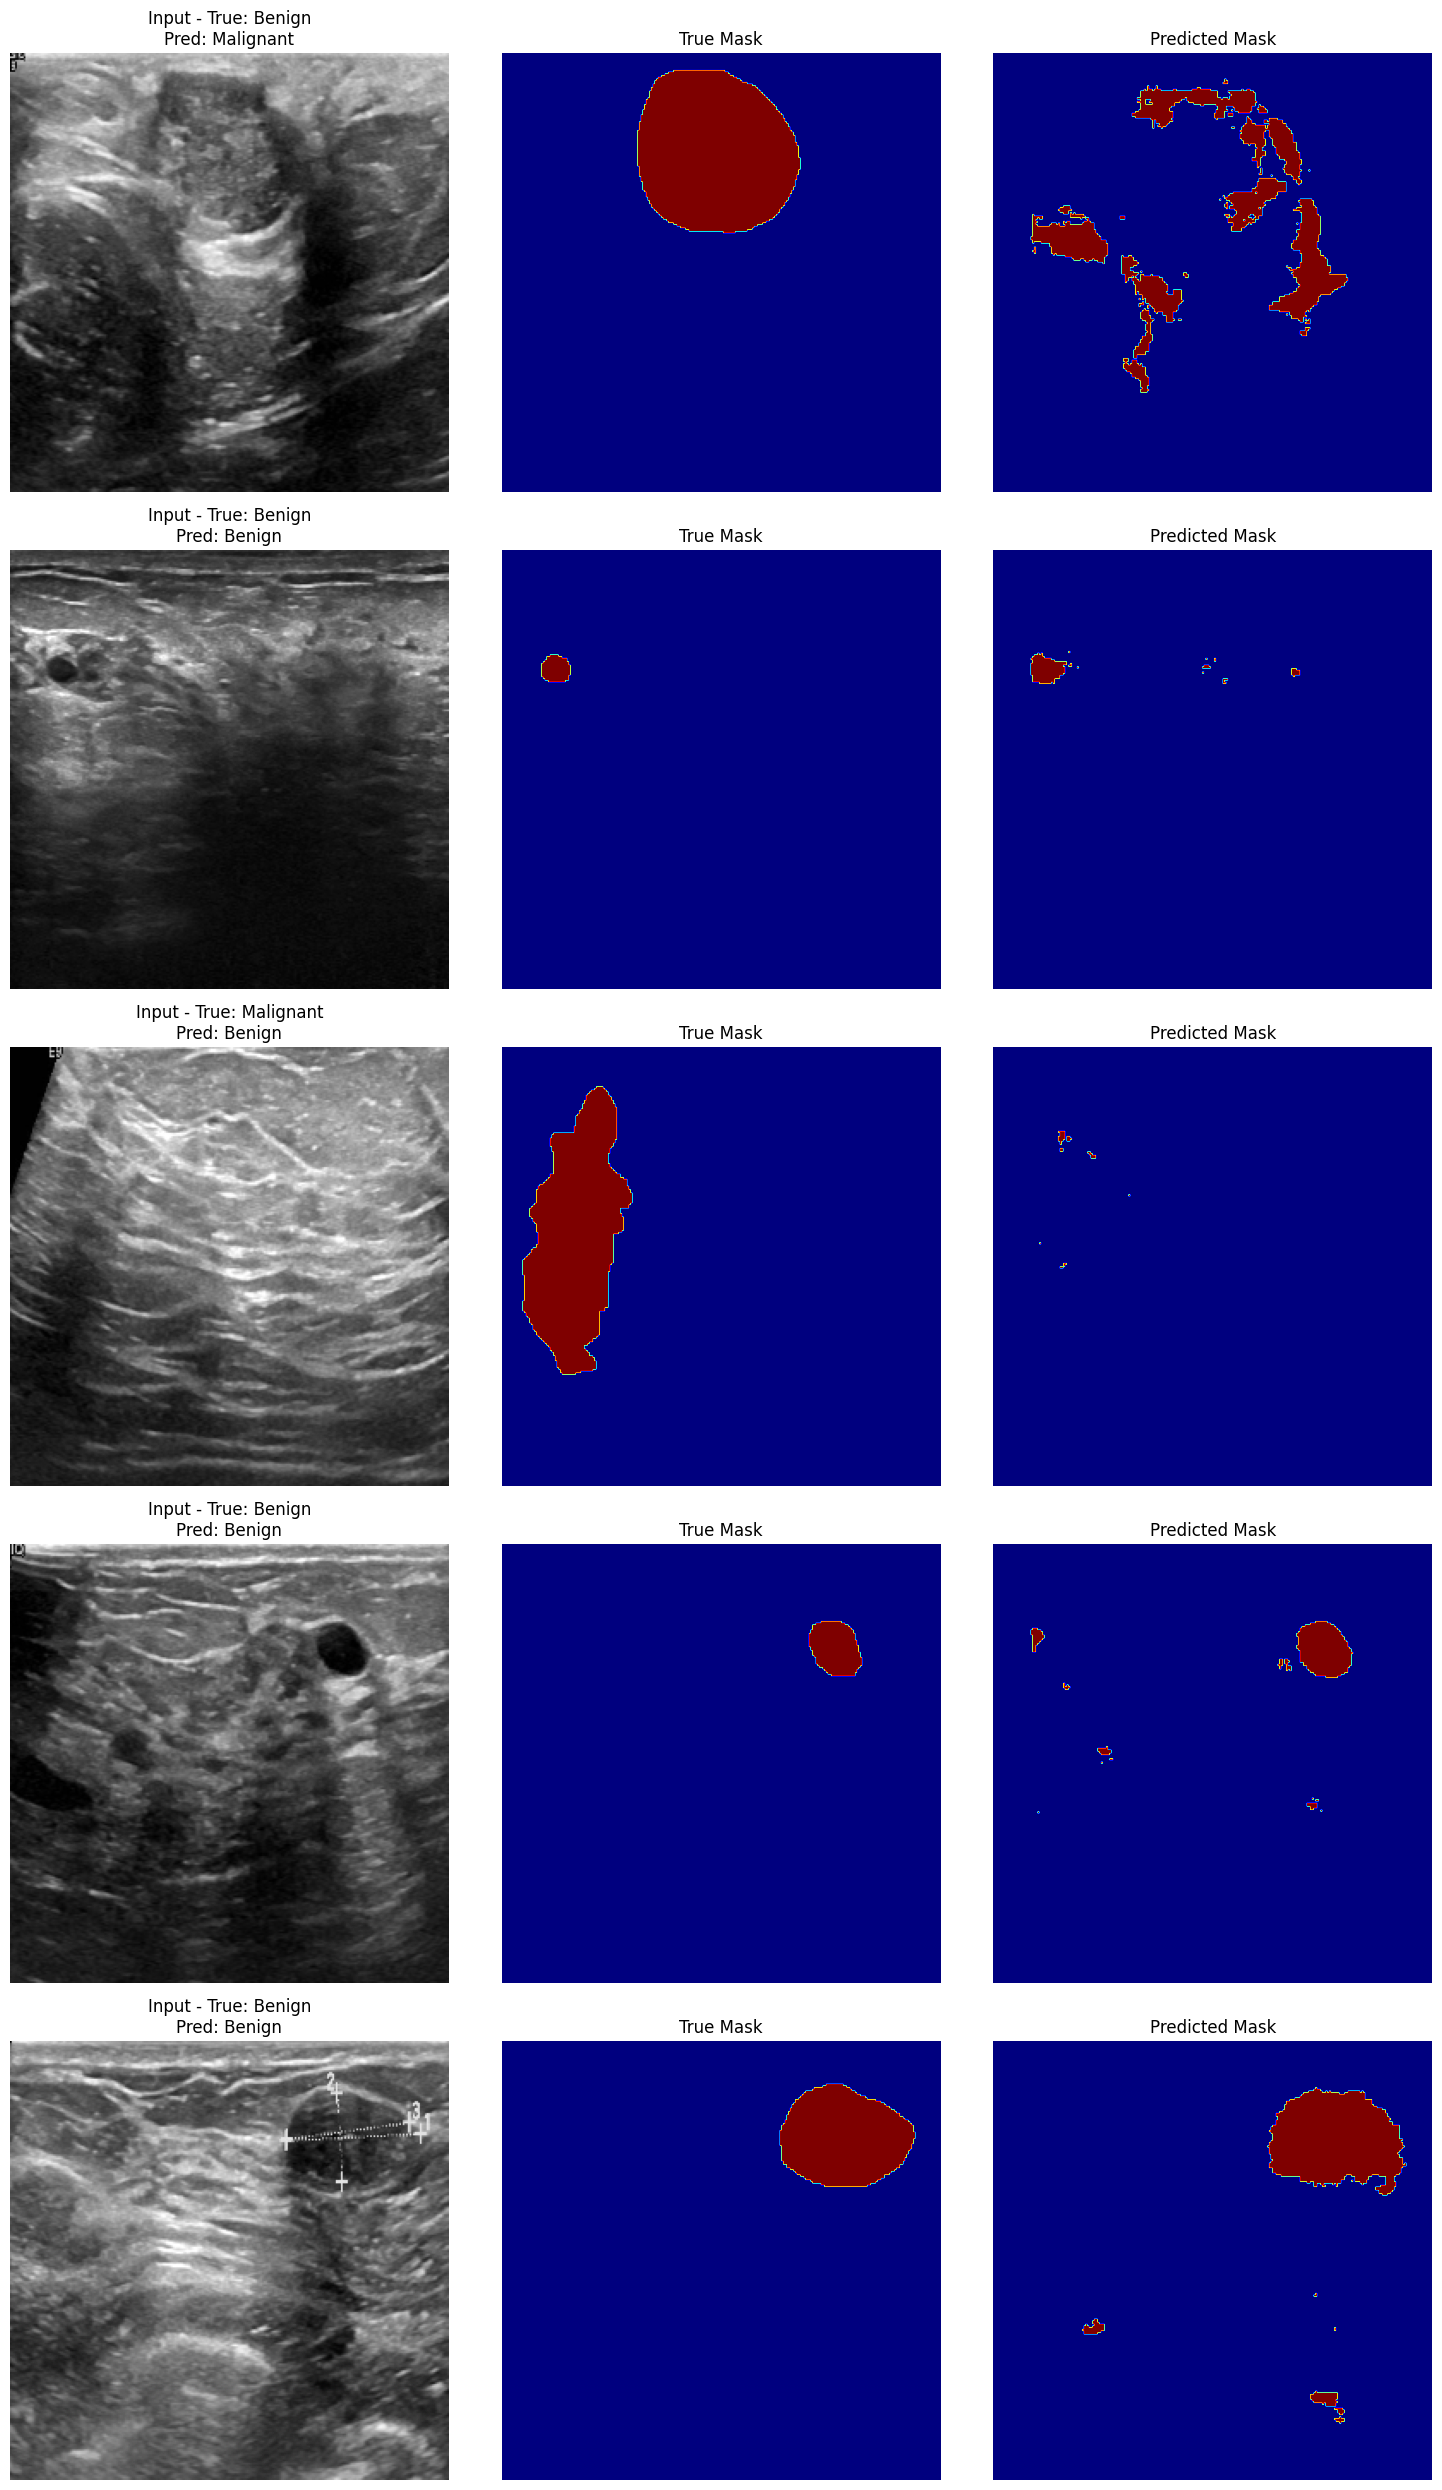

In [17]:
# Cell 14

import matplotlib.pyplot as plt

num_examples = 5

for batch in val_dataset.take(1):
    x_batch, y_batch = batch
    break

y_seg_true = y_batch['seg_output'].numpy()
y_cls_true = np.argmax(y_batch['cls_output'].numpy(), axis=1)

predictions = model.predict(x_batch)
seg_preds = predictions['seg_output']
cls_preds = predictions['cls_output']
cls_pred_labels = np.argmax(cls_preds, axis=1)

seg_preds_binary = (seg_preds > 0.5).astype(np.float32)

class_names = ['Normal', 'Benign', 'Malignant']

plt.figure(figsize=(15, 5 * num_examples))

for i in range(num_examples):
    plt.subplot(num_examples, 3, i * 3 + 1)
    plt.imshow(x_batch[i, :, :, 0], cmap='gray')
    plt.title(f"Input - True: {class_names[y_cls_true[i]]}\nPred: {class_names[cls_pred_labels[i]]}")
    plt.axis('off')

    plt.subplot(num_examples, 3, i * 3 + 2)
    plt.imshow(y_seg_true[i, :, :, 0], cmap='jet')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(num_examples, 3, i * 3 + 3)
    plt.imshow(seg_preds_binary[i, :, :, 0], cmap='jet')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.savefig('prediction_visualization.png', dpi=300, bbox_inches='tight')
plt.show()